# Photoinjector simulation in Volume
Let's simulate a CLEAR-like photoinjector.
We need to use Volume because we need the:
* Full overlap of field maps: electron gun's electric field + solenoid field
* Time integration to correctly model space-charge effects

In [1]:
import RF_Track as RFT
import numpy as np
import scipy
import matplotlib.pyplot as plt
import time

In [2]:
import scripts

## Define the key parameters

In [3]:
# Structure "setup"
class Setup:
    def __init__(self):
        self.Bz = 0.25 # T, solendoid peak field
        self.Ez = 100 # MV/m, gun gradient
        self.PHID = 140 # deg, gun phase
setup = Setup()
Q_pC = 50 # pC, bunch charge extracted
sigr = 0.8 # mmm, laser spot size at the cathode
sigt = 1.2 # ps, laser pulse length

## Beam creation at cathode
To create a suitable particles distribution, we can use a generator similar to the ASTRA's one. For more information, see [HERE](https://indico.cern.ch/event/1186676/).

In [4]:
Nparticles = 5000 # number of macroparticles

# Beam creation at cathode
G = RFT.Bunch6dT_Generator();
G.species = 'electrons'          # species
G.cathode = True                 # cathode, true or false
G.noise_reduc = True             # noise reduction (quasi-random)
G.q_total = Q_pC/1e3             # nC bunch charge
G.ref_ekin = 0                   # MeV energy of reference particle
G.ref_zpos = 0                   # m position of reference particle
G.ref_clock = 0                  # ns clock of reference particle
G.phi_eff = 3.5                  # eV, effective work function
G.e_photon = 4.73                # eV, photon energy for Fermi-Dirac distribution.
G.dist_x = 'g'                   # Specifies the transverse particle distribution in the horizontal direction.
G.dist_y = 'g'                   # Specifies the transverse particle distribution in the vertical direction.
G.sig_x = sigr                   # mm, rms bunch size in the horizontal direction. Also the vertical bunch size if Dist_x = radial.
G.sig_y = sigr                   # mm, rms bunch size in the vertical direction.
G.sig_t = sigt/1e3               # ns, rms value of the emission time, i.e. the bunch length if generated from a cathode
G.c_sig_x = 3                    # cuts off a Gaussian horizontal distribution
G.c_sig_y = 3                    # cuts off a Gaussian vertical distribution
G.c_sig_t = 3                    # cuts off a Gaussian longitudinal distribution
G.dist_pz = 'fd_300'             # Emission from cathode following a Fermi-Dirac dist. (for z)
B0 = RFT.Bunch6dT(G, Nparticles)

Text(0.5, 0, '$t_0$ [ps]')

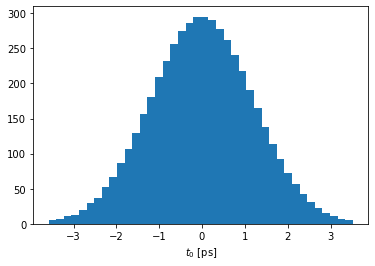

In [5]:
# Let's display the phase space, which, for a Bunch6dT, is by default X Px Y Py Z Pz

M0 = B0.get_phase_space()
M0[:10,:]

t0 = B0.get_phase_space('%t0')
plt.hist(t0 / RFT.ps, 40)
plt.xlabel(r'$t_0$ [ps]')

## We load the gun and the solenoid field maps

In [6]:
Gun, GunS = scripts.init_gun(setup, 'data/GUN_ideal_SF_100.txt');
Sol, SolS = scripts.init_solenoid(setup, 'data/profile_califes_bon_B1_285_B3_338.txt')

In [7]:
print(GunS)
print(SolS)

0.0
-1.063


We add the elements to the Volume using: ```V.add (Gun, ...);```
* ```V.add (Gun, X, Y, Z, 'entrance');```
* ```V.add (Gun, X, Y, Z, ROLL, PITCH, YAW, 'entrance');```

In [8]:
## We define the volume
V = RFT.Volume()
V.add(Gun, 0, 0, GunS)
V.add(Sol, 0, 0, SolS)
V.set_s0(0.0) # entrance boundary
V.set_s1(1.0) # exit boundary

In [9]:
print(V.get_s0())
print(V.get_s1())

[[0. 0. 0. 1. 0. 0. 0.]]
[[   0.    0. 1000.    1.    0.    0.    0.]]


## Let's plot the fields

In [10]:
Za = np.linspace(0, 1000, 500) # mm, Z axis
O = np.zeros((1,500))
I = np.ones((1,500))

E, B = V.get_field( O, O, Za, I*40 ) # X, Y, Z, T
fig, ax = plt.subplots()
ax.plot(Za/1e3, E[:,2]/1e6, 'C00')
ax1 = ax.twinx()
ax1.plot(Za/1e3, B[:,2], 'C01')
ax.set_xlabel('S [m]')
ax.set_ylabel(r'$E_z$ [MV/m]')
ax1.set_ylabel(r'$B_z$ [T]')

Text(0, 0.5, '$B_z$ [T]')

We need now to setup the tracking options

In [11]:
V.odeint_algorithm = 'rk2' # pick your favourite algorithm, 'rk2', 'rkf45', 'leapfrog', and 'analytic' are valid options
V.dt_mm = 0.1 # mm/c, integration step size
V.sc_dt_mm = 5 # mm/c, the time step of the space-charge effect calculation
V.tt_dt_mm = 5 # mm/c, the time step with which the transport table is filled

Now we can perform tracking

In [12]:
t0 = time.time()
B1 = V.track(B0)
print(f'Elapsed time is {time.time() - t0:.2f} seconds')

Elapsed time is 8.32 seconds


## Phase space plots

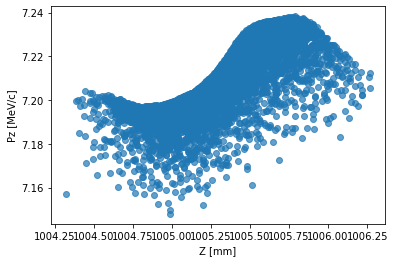

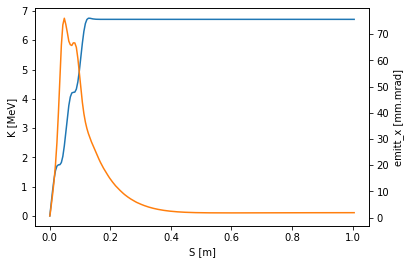

In [13]:
M1 = B1.get_phase_space()

plt.figure()
plt.scatter(M1[:,4], M1[:,5], alpha=0.7)
plt.xlabel('Z [mm]')
plt.ylabel('Pz [MeV/c]')

T = V.get_transport_table('%t %mean_Z %mean_K %emitt_x')
fig, ax = plt.subplots()
ax1 = ax.twinx()
ax.plot(T[:,1]/1e3, T[:,2], 'C00')
ax1.plot(T[:,1]/1e3, T[:,3], 'C01')
ax.set_xlabel('S [m]')
ax.set_ylabel('K [MeV]');
ax1.set_ylabel('emitt_x [mm.mrad]');

Volume uses Z and Pz as longitudinal phase space coordinates (canonical pair)
Lattice uses t and E as longitudinal phase space coordinates (canonical pair)

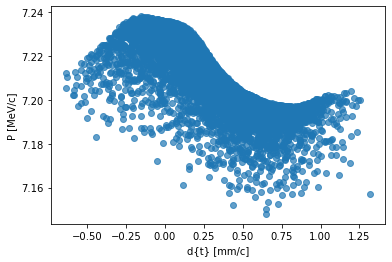

In [14]:
B1_6d = V.get_bunch_at_s1()
M1_6d = B1_6d.get_phase_space('%dt %P')

plt.figure()
plt.scatter(M1_6d[:, 0], M1_6d[:, 1], alpha=0.7)
plt.xlabel('d{t} [mm/c]')
plt.ylabel('P [MeV/c]')
plt.show()

## Adjusting the space charge calculation and considering the effect of cathode mirror charges
Cathode mirror charges affect the beam dynamics through space-charge forces and can alter the effective charge extracted from a cathode.

We can set them by setting the RF-Track's space-charge computing engine accordingly. (This is typically done at the beginning of a script.)

In [15]:
## Let's customize the SC algorithm.
SC = RFT.SpaceCharge_PIC_FreeSpace (32, 32, 32) # The three inputs are the number of mesh cells in X, Y, and Z.
SC.set_smooth (0.5) # set smooth factor
SC.set_mirror (0.0) # set position of cathode

## Set RF-Track to use 'SC' for space-charge calculations
RFT.cvar.SC_engine = SC

### Let's re-run the simulation

In [16]:
t0 = time.time()
B1 = V.track(B0)
print(f'Elapsed time is {time.time() - t0:.2f} seconds')

Elapsed time is 8.22 seconds


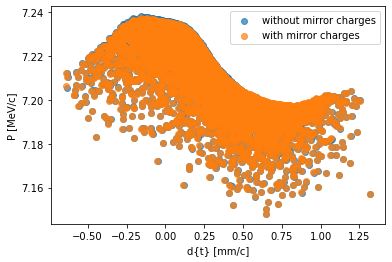

In [17]:
B1_6d = V.get_bunch_at_s1()
M1_6d_mirror = B1_6d.get_phase_space('%dt %P')

plt.figure()
plt.scatter(M1_6d[:, 0], M1_6d[:, 1], label='without mirror charges', alpha=0.7)
plt.scatter(M1_6d_mirror[:, 0], M1_6d_mirror[:, 1], label='with mirror charges', alpha=0.7)
plt.xlabel('d{t} [mm/c]')
plt.ylabel('P [MeV/c]')
plt.legend(loc='best')
plt.show()

## Using Volume as a Lattice element
A Volume can be inserted into a Lattice. In this case, the incoming Bunch6d is placed at s0, and the tracking continues in Volume until the particles reach s1.

Let's see an example:

In [18]:
# Structure "setup"
class Setup_linac:
    def __init__(self):
        self.Q = -1 # single-particle charge, in units of e
        self.mass = RFT.electronmass # MeV/c^2
        self.population = RFT.nC # 50 * RFT.pC; % number of real particles per bunch
        
        self.sigma_t = 0.100 # mm/c
        self.sigma_pt = 0.1 # permille, momentum spread

        self.P_i = 100 # initial momentum, MeV/c
        self.P_f = 500 # final momentum, MeV/c

        self.phid = -27 # deg, phase of the RF structures
        self.mu = 90 # deg, FODO phase advance per cell

In [19]:
L = RFT.Lattice()
rf_name = 'data/TWS_Xband.dat'
LINAC = scripts.init_linac_lattice (rf_name, Setup_linac())
L.append(V)
L.append(LINAC)